In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import scipy.sparse as sp
import numpy as np
from tensorflow.contrib.rnn import RNNCell
import tensorflow as tf
from tensorflow.python.platform import tf_logging as logging
import pickle as pkl
import tensorflow as tf
import pandas as pd
import numpy as np
import math
import os
import numpy.linalg as la
from sklearn.metrics import mean_squared_error,mean_absolute_error
#import matplotlib.pyplot as plt
import time
time_start=time.time()

In [2]:
# Loading of Dataset-SZ Traffic
def load_sz_data():
    sz_adj = pd.read_csv('sz_adj.csv',header=None)
    adj = np.mat(sz_adj)
    sz_tf = pd.read_csv('sz_speed.csv')
    return sz_tf, adj

data, adj = load_sz_data()

In [3]:
print(data) # Time sequence data

          90217      90218      90219      90220      90221      90222  \
0      8.471971  18.455410  20.590635  15.345258   9.585218  21.501821   
1      7.807137  15.713816  27.523695  11.087895   9.455280  17.332246   
2      8.809457   8.979647  20.280394  16.523419   8.003314  15.789483   
3     51.590372  23.631243  20.224094  15.116459   6.642644  17.575806   
4     58.770433  20.437740  20.465606  14.820217  11.344404   0.000000   
5     58.289126  10.332738  25.331018  18.485616   2.028513  10.718488   
6     61.334449  20.818480  15.839392   8.768217  13.933326  13.866124   
7     58.903144   8.291826  44.043729  15.250859   0.000000   0.000000   
8     57.210441  25.765667  18.677565   5.066051   0.000000  12.645903   
9     59.559265  16.803983  20.314610  23.393083   2.612821   0.000000   
10    60.217867  26.773576  17.684078  17.735375  12.957171   7.404007   
11    56.336405  18.866552  27.502295  18.201105  23.973238  22.215358   
12    58.511395  15.802270  15.900551 

In [4]:
print(adj) #Adjacency Matrix of Data

[[0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 1 1 0]]


In [5]:
print(data.shape)
time_len=data.shape[0] # Time sequence length
num_nodes=data.shape[1] #Number of Roads

(2976, 156)


In [6]:
# Setting the variables
output_dim=pre_len=1
seq_len=4
num_units=100
train_rate=0.8
batch_size=32

In [7]:
#Normalization : Traffic Speed Data

data1 =np.mat(data,dtype=np.float32)

max_value = np.max(data1)
data1  = data1/max_value
print(data1)

   

[[0.0980221  0.21353212 0.23823702 ... 0.19194394 0.37707424 0.        ]
 [0.09032986 0.18181142 0.31845367 ... 0.45834997 0.37705195 0.        ]
 [0.10192686 0.10389599 0.23464748 ... 0.3856561  0.43354756 0.        ]
 ...
 [0.37947276 0.141638   0.10453826 ... 0.13605069 0.1998609  0.        ]
 [0.39722532 0.18600048 0.121989   ... 0.16306393 0.16957766 0.        ]
 [0.38101357 0.14001252 0.10420388 ... 0.19054307 0.1845446  0.        ]]


In [8]:
def preprocess_data(data, time_len, rate, seq_len, pre_len):
    train_size = int(time_len * rate) #2976 *0.8 =2380
    train_data = data[0:train_size] #  [0:2380]
    test_data = data[train_size:time_len] #[2380:2976]
    print(train_data.shape,'----->',test_data.shape)

    trainX, trainY, testX, testY = [], [], [], []
    for i in range(len(train_data) - seq_len - pre_len): #(2380-4-1)=2375
        a = train_data[i: i + seq_len + pre_len] #[0:0+4+1] =[0:5]
        trainX.append(a[0 : seq_len]) #a[0:4] 4 time * 156 roads
        trainY.append(a[seq_len : seq_len + pre_len]) #a[4:4+1] 1 time*156 
    for i in range(len(test_data) - seq_len -pre_len):
        b = test_data[i: i + seq_len + pre_len]
        testX.append(b[0 : seq_len])
        testY.append(b[seq_len : seq_len + pre_len])
      
    trainX1 = np.array(trainX) 
    trainY1 = np.array(trainY)
    testX1 = np.array(testX)
    testY1 = np.array(testY)
    return trainX1, trainY1, testX1, testY1

trainX, trainY, testX, testY = preprocess_data(data1, time_len, train_rate, seq_len, pre_len)

totalbatch = int(trainX.shape[0]/batch_size)
training_data_count = len(trainX)  
print('Train Test Split Details :')
print('Train x ----> ',len(trainX))
print('Train y ----> ',len(trainY))
print(trainX.shape)
print('Test x ----> ',len(testX))
print('Test y ----> ',len(testY))
#print('\nTrain Sample Details :')
#print(trainX[0],'--->',trainY[0])


(2380, 156) -----> (596, 156)
Train Test Split Details :
Train x ---->  2375
Train y ---->  2375
(2375, 4, 156)
Test x ---->  591
Test y ---->  591


In [9]:
def weight_variable_glorot(input_dim, output_dim, name=""):
        init_range = np.sqrt(6.0 / (input_dim + output_dim))
        initial = tf.random_uniform([input_dim, output_dim], minval=-init_range, maxval=init_range, dtype=tf.float32)
        return tf.Variable(initial,name=name)

In [10]:
class stgcnCell(RNNCell):
    """Temporal Graph Convolutional Network """

    def call(self, inputs, **kwargs):
        pass

    def __init__(self, num_units, adj, num_nodes, input_size=None,
                 act=tf.nn.tanh, reuse=None):

        super(stgcnCell, self).__init__(_reuse=reuse)
        self._act = act
        self._nodes = num_nodes
        self._units = num_units
        self._adj = []
        self._adj.append(self.calculate_laplacian(adj))

    @staticmethod
    def _build_sparse_matrix(L):
        L = L.tocoo()
        indices = np.column_stack((L.row, L.col))
        L = tf.SparseTensor(indices, L.data, L.shape)
        return tf.sparse_reorder(L)

    def calculate_laplacian(self,adj, lambda_max=1):  
        adj = self.normalized_adj(adj + sp.eye(adj.shape[0])) # normalisation(self identity matrix + adj)
        adj = sp.csr_matrix(adj) #compressed sparse matrix
        adj = adj.astype(np.float32)
        return self.sparse_to_tuple(adj)
    
    def normalized_adj(self,adj):
        adj = sp.coo_matrix(adj)
        degree = np.array(adj.sum(1)) # Degree Matrix row wise sum
        d_inv_sqrt = np.power(degree, -0.5).flatten() # D inv = Degree ^-0.5 
        d_mat_inv_sqrt = sp.diags(d_inv_sqrt) #substitution of the 1D array degree in a 2D matrix diagonals
        normalized_adj = adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo() # norm= D^-0.5 * adj * D^-0.5
        normalized_adj = normalized_adj.astype(np.float32) 
        return normalized_adj
    
    def sparse_to_tuple(self,mx):
        mx = mx.tocoo()
        coords = np.vstack((mx.row, mx.col)).transpose() #coordinate stacking row and column wise and transpose
        L = tf.SparseTensor(coords, mx.data, mx.shape) # mx.shape= (156,156)
        #print('shape ---->',mx.shape)
        return tf.sparse_reorder(L) #row major ordering
        
    def init_state(self,batch_size):       
        state = tf.zeros(shape=[batch_size, self._num_nodes*self._num_units], dtype=tf.float32)
        return state  
               
    @staticmethod
    def _concat(x, x_):
        x_ = tf.expand_dims(x_, 0)
        return tf.concat([x, x_], axis=0)   
    @property
    def state_size(self):
        return self._nodes * self._units

    @property
    def output_size(self):
        return self._units

    def __call__(self, inputs, state, scope=None):

        with tf.variable_scope(scope or "tgcn"):
            with tf.variable_scope("gates"):  
                value = tf.nn.sigmoid(
                    self._gc(inputs, state, 2 * self._units, bias=1.0, scope=scope)) #ut (or) rt = sigma(Wu [f(A;Xt); h{t-1}] + bu)
                r, u = tf.split(value=value, num_or_size_splits=2, axis=1)
            with tf.variable_scope("candidate"):
                r_state = r * state #r* h{t-1}
                c = self._act(self._gc(inputs, r_state, self._units, scope=scope))#ct = tanh(Wc [f(A;Xt); r_state] + bc) 
            new_h = u * state + (1 - u) * c #ht = ut * h{t-1} + (1 - u{t}) * ct
        return new_h, new_h


    def _gc(self, inputs, state, output_size, bias=0.0, scope=None):
        ## inputs:(-1,num_nodes)
        inputs = tf.expand_dims(inputs, 2)#None,156,None
        ## state:(batch,num_node,gru_units)
        state = tf.reshape(state, (-1, self._nodes, self._units)) #32,156,64
        ## concat
        x_s = tf.concat([inputs, state], axis=2) #32,156,65
        input_size = x_s.get_shape()[2].value #65
        ## (num_node,input_size,-1)
        x0 = tf.transpose(x_s, perm=[1, 2, 0]) #156,65,32
        x0 = tf.reshape(x0, shape=[self._nodes, -1]) #156,65*32
        scope = tf.get_variable_scope()
        with tf.variable_scope(scope):
            for m in self._adj:#1,156
                x1 = tf.sparse_tensor_dense_matmul(m, x0) #1,65*32
#                print(x1)
            x = tf.reshape(x1, shape=[self._nodes, input_size,-1]) #156,65,32
            x = tf.transpose(x,perm=[2,0,1]) #32,156,65
            x = tf.reshape(x, shape=[-1, input_size]) #156*32,65
            weights = tf.get_variable( # 65,64
                'weights', [input_size, output_size], initializer=tf.contrib.layers.xavier_initializer())
            x = tf.matmul(x, weights)  # (batch_size * self._nodes, output_size) 
            biases = tf.get_variable( #64
                "biases", [output_size], initializer=tf.constant_initializer(bias, dtype=tf.float32))
            x = tf.nn.bias_add(x, biases) #biases added
            x = tf.reshape(x, shape=[-1, self._nodes, output_size]) #32,156,64
            x = tf.reshape(x, shape=[-1, self._nodes * output_size])#32,156*64
        return x

In [11]:
#inputs = tf.convert_to_tensor(trainX, np.float32)
#labels = tf.placeholder(tf.float32, shape=[None, pre_len, num_nodes])
#g=stgcnCell(num_units, adj, inputs, output_dim)

In [12]:
def STGCN(_X, _weights, _biases):
    ###
    cell_1 = stgcnCell(num_units, adj, num_nodes=num_nodes)
    cell = tf.nn.rnn_cell.MultiRNNCell([cell_1], state_is_tuple=True) #stack rnn cells
    _X = tf.unstack(_X, axis=1) # 4 tensorflow arrays of shape None,156 (seq_len=4)
    outputs, states = tf.nn.static_rnn(cell, _X, dtype=tf.float32) #Creates a recurrent neural network specified by RNNCell cell
    #4 outputs and 1 state None,9984(156*64)
    m = []
    for i in outputs:
        o = tf.reshape(i,shape=[-1,num_nodes,num_units])#None,156,64
        o = tf.reshape(o,shape=[-1,num_units])#None*156,64
        m.append(o) #4 objects
    last_output = m[-1] #last one
    output = tf.matmul(last_output, _weights['out']) + _biases['out'] #multiply with weights and add bias None*156,1+len(1)=156,1
    output = tf.reshape(output,shape=[-1,num_nodes,pre_len]) # None,156,1
    output = tf.transpose(output, perm=[0,2,1])#None,1,156
    output = tf.reshape(output, shape=[-1,num_nodes]) #None*1,156
    return output, m, states

In [13]:
inputs = tf.placeholder(tf.float32, shape=[None, seq_len, num_nodes])
labels = tf.placeholder(tf.float32, shape=[None, pre_len, num_nodes])
weights = {
    'out': tf.Variable(tf.random_normal([num_units, pre_len], mean=1.0), name='weight_o')} #64,1
biases = {
    'out': tf.Variable(tf.random_normal([pre_len]),name='bias_o')} #1
print(type(inputs))
pred,ttts,ttto = STGCN(inputs, weights, biases)

Instructions for updating:
Colocations handled automatically by placer.
<class 'tensorflow.python.framework.ops.Tensor'>
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API


In [14]:
y_pred = pred

In [15]:
lambda_loss = 0.0015
Lreg = lambda_loss * sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())
label = tf.reshape(labels, [-1,num_nodes])

In [16]:
loss = tf.reduce_mean(tf.nn.l2_loss(y_pred-label) + Lreg)

In [17]:
error = tf.sqrt(tf.reduce_mean(tf.square(y_pred-label)))

In [18]:
lr=0.001
optimizer = tf.train.AdamOptimizer(lr).minimize(loss)

In [19]:
variables = tf.global_variables()
training_epoch=1000
saver = tf.train.Saver(tf.global_variables()) #
#sess = tf.Session()
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
sess.run(tf.global_variables_initializer())
out = 'out/%s'%("STGCN")
#out = 'out/%s_%s'%(model_name,'perturbation')
path1 = '%s_%s_lr%r_batch%r_unit%r_seq%r_pre%r_epoch%r'%("STGCN","sz",lr,batch_size,num_units,seq_len,pre_len,training_epoch)
path = os.path.join(out,path1)
if not os.path.exists(path):
    os.makedirs(path)

In [20]:
def evaluation(a,b):
    rmse = math.sqrt(mean_squared_error(a,b))
    mae = mean_absolute_error(a, b)
    F_norm = la.norm(a-b,'fro')/la.norm(a,'fro')
    r2 = 1-((a-b)**2).sum()/((a-a.mean())**2).sum()
    var = 1-(np.var(a-b))/np.var(a)
    return rmse, mae, 1-F_norm, r2, var

In [21]:
x_axe,batch_loss,batch_rmse,batch_pred = [], [], [], []
test_loss,test_rmse,test_mae,test_acc,test_r2,test_var,test_pred = [],[],[],[],[],[],[]

In [22]:
def acc(a,b):  
    F_norm = la.norm(a-b,'fro')/la.norm(a,'fro')
    train_acc=1-F_norm
    return train_acc

In [23]:
for epoch in range(training_epoch):
    print("Epoch ", epoch)
    for m in range(totalbatch):
        mini_batch = trainX[m * batch_size : (m+1) * batch_size]
        mini_label = trainY[m * batch_size : (m+1) * batch_size]
        _, loss1, rmse1, train_output = sess.run([optimizer, loss, error, y_pred],
                                                 feed_dict = {inputs:mini_batch, labels:mini_label})
        batch_loss.append(loss1)
        batch_rmse.append(rmse1 * max_value)
        train_label=np.reshape(mini_label,[-1,num_nodes])
     #print(mini_label.shape,train_output.shape) (32, 1, 156) (32, 156)
     # Test completely at every epoch
    print("Accuracy ----> ", evaluation(train_label,train_output)[2])
    loss2, rmse2, test_output = sess.run([loss, error, y_pred],
                                         feed_dict = {inputs:testX, labels:testY})
    #train_label=np.reshape(trainY,[-1,num_nodes])
    #train_acc=acc(train_label,train_output)
    test_label = np.reshape(testY,[-1,num_nodes])
    rmse, mae, acc, r2_score, var_score = evaluation(test_label, test_output)
    test_label1 = test_label * max_value#Inverse normalization
    test_output1 = test_output * max_value
    test_loss.append(loss2)
    test_rmse.append(rmse * max_value)
    test_mae.append(mae * max_value)
    test_acc.append(acc)
    test_r2.append(r2_score)
    test_var.append(var_score)
    test_pred.append(test_output1)
    #print(mini_label.shape,train_output.shape)
    print('Iter:{}'.format(epoch),
          'train_rmse:{:.4}'.format(batch_rmse[-1]),
          'test_loss:{:.4}'.format(loss2),
          'test_rmse:{:.4}'.format(rmse),
          'test_acc:{:.4}'.format(acc))
    if (epoch % 500 == 0):        
        saver.save(sess, path+'/model_10015TGCN_pre_%r'%epoch, global_step = epoch)
        
time_end = time.time()
print('Time taken : ',time_end-time_start,'s')

Epoch  0
Accuracy ---->  0.6102120280265808
Iter:0 train_rmse:5.625 test_loss:222.4 test_rmse:0.06938 test_acc:0.5823
Epoch  1
Accuracy ---->  0.6152190566062927
Iter:1 train_rmse:5.553 test_loss:215.9 test_rmse:0.06836 test_acc:0.5884
Epoch  2
Accuracy ---->  0.6161063313484192
Iter:2 train_rmse:5.54 test_loss:214.6 test_rmse:0.06815 test_acc:0.5897
Epoch  3
Accuracy ---->  0.6164804697036743
Iter:3 train_rmse:5.534 test_loss:213.9 test_rmse:0.06805 test_acc:0.5903
Epoch  4
Accuracy ---->  0.6168162524700165
Iter:4 train_rmse:5.53 test_loss:213.4 test_rmse:0.06797 test_acc:0.5908
Epoch  5
Accuracy ---->  0.6172611713409424
Iter:5 train_rmse:5.523 test_loss:212.9 test_rmse:0.06789 test_acc:0.5913
Epoch  6
Accuracy ---->  0.6177465319633484
Iter:6 train_rmse:5.516 test_loss:212.4 test_rmse:0.06781 test_acc:0.5918
Epoch  7
Accuracy ---->  0.6182535886764526
Iter:7 train_rmse:5.509 test_loss:211.8 test_rmse:0.06772 test_acc:0.5923
Epoch  8
Accuracy ---->  0.6187959909439087
Iter:8 train_r

Accuracy ---->  0.6582269370555878
Iter:69 train_rmse:4.932 test_loss:178.3 test_rmse:0.0621 test_acc:0.6261
Epoch  70
Accuracy ---->  0.6589884459972382
Iter:70 train_rmse:4.921 test_loss:177.6 test_rmse:0.06196 test_acc:0.6269
Epoch  71
Accuracy ---->  0.6597726345062256
Iter:71 train_rmse:4.91 test_loss:176.8 test_rmse:0.06183 test_acc:0.6277
Epoch  72
Accuracy ---->  0.6605752408504486
Iter:72 train_rmse:4.898 test_loss:176.1 test_rmse:0.0617 test_acc:0.6285
Epoch  73
Accuracy ---->  0.661386102437973
Iter:73 train_rmse:4.886 test_loss:175.3 test_rmse:0.06157 test_acc:0.6293
Epoch  74
Accuracy ---->  0.6621928811073303
Iter:74 train_rmse:4.875 test_loss:174.6 test_rmse:0.06144 test_acc:0.6301
Epoch  75
Accuracy ---->  0.662984699010849
Iter:75 train_rmse:4.863 test_loss:173.9 test_rmse:0.06132 test_acc:0.6308
Epoch  76
Accuracy ---->  0.6637539565563202
Iter:76 train_rmse:4.852 test_loss:173.2 test_rmse:0.06119 test_acc:0.6316
Epoch  77
Accuracy ---->  0.6644959449768066
Iter:77 tr

Accuracy ---->  0.6867814064025879
Iter:137 train_rmse:4.52 test_loss:155.0 test_rmse:0.05786 test_acc:0.6516
Epoch  138
Accuracy ---->  0.6868138909339905
Iter:138 train_rmse:4.519 test_loss:154.7 test_rmse:0.0578 test_acc:0.652
Epoch  139
Accuracy ---->  0.6868619620800018
Iter:139 train_rmse:4.519 test_loss:154.4 test_rmse:0.05774 test_acc:0.6523
Epoch  140
Accuracy ---->  0.6869294345378876
Iter:140 train_rmse:4.518 test_loss:154.0 test_rmse:0.05769 test_acc:0.6527
Epoch  141
Accuracy ---->  0.6870155036449432
Iter:141 train_rmse:4.517 test_loss:153.7 test_rmse:0.05763 test_acc:0.653
Epoch  142
Accuracy ---->  0.6871172487735748
Iter:142 train_rmse:4.515 test_loss:153.4 test_rmse:0.05757 test_acc:0.6534
Epoch  143
Accuracy ---->  0.6872313022613525
Iter:143 train_rmse:4.513 test_loss:153.2 test_rmse:0.05752 test_acc:0.6537
Epoch  144
Accuracy ---->  0.6873547434806824
Iter:144 train_rmse:4.512 test_loss:152.9 test_rmse:0.05747 test_acc:0.654
Epoch  145
Accuracy ---->  0.68748533725

Accuracy ---->  0.6967883408069611
Iter:205 train_rmse:4.376 test_loss:143.6 test_rmse:0.05568 test_acc:0.6648
Epoch  206
Accuracy ---->  0.6969407200813293
Iter:206 train_rmse:4.373 test_loss:143.5 test_rmse:0.05566 test_acc:0.6649
Epoch  207
Accuracy ---->  0.6970947086811066
Iter:207 train_rmse:4.371 test_loss:143.4 test_rmse:0.05564 test_acc:0.665
Epoch  208
Accuracy ---->  0.697249561548233
Iter:208 train_rmse:4.369 test_loss:143.3 test_rmse:0.05562 test_acc:0.6651
Epoch  209
Accuracy ---->  0.6974051594734192
Iter:209 train_rmse:4.367 test_loss:143.2 test_rmse:0.0556 test_acc:0.6653
Epoch  210
Accuracy ---->  0.6975614130496979
Iter:210 train_rmse:4.364 test_loss:143.1 test_rmse:0.05558 test_acc:0.6654
Epoch  211
Accuracy ---->  0.6977185308933258
Iter:211 train_rmse:4.362 test_loss:143.0 test_rmse:0.05556 test_acc:0.6655
Epoch  212
Accuracy ---->  0.6978755593299866
Iter:212 train_rmse:4.36 test_loss:142.9 test_rmse:0.05554 test_acc:0.6656
Epoch  213
Accuracy ---->  0.6980329155

Accuracy ---->  0.7051019072532654
Iter:273 train_rmse:4.256 test_loss:136.0 test_rmse:0.05419 test_acc:0.6738
Epoch  274
Accuracy ---->  0.7051952481269836
Iter:274 train_rmse:4.254 test_loss:135.9 test_rmse:0.05416 test_acc:0.6739
Epoch  275
Accuracy ---->  0.7052875757217407
Iter:275 train_rmse:4.253 test_loss:135.8 test_rmse:0.05414 test_acc:0.674
Epoch  276
Accuracy ---->  0.70537930727005
Iter:276 train_rmse:4.252 test_loss:135.7 test_rmse:0.05412 test_acc:0.6742
Epoch  277
Accuracy ---->  0.7054711580276489
Iter:277 train_rmse:4.25 test_loss:135.6 test_rmse:0.0541 test_acc:0.6743
Epoch  278
Accuracy ---->  0.7055622935295105
Iter:278 train_rmse:4.249 test_loss:135.5 test_rmse:0.05408 test_acc:0.6744
Epoch  279
Accuracy ---->  0.7056531012058258
Iter:279 train_rmse:4.248 test_loss:135.4 test_rmse:0.05406 test_acc:0.6745
Epoch  280
Accuracy ---->  0.7057445049285889
Iter:280 train_rmse:4.246 test_loss:135.3 test_rmse:0.05404 test_acc:0.6747
Epoch  281
Accuracy ---->  0.70583558082

Accuracy ---->  0.7112118303775787
Iter:341 train_rmse:4.167 test_loss:128.4 test_rmse:0.05264 test_acc:0.6831
Epoch  342
Accuracy ---->  0.7113080620765686
Iter:342 train_rmse:4.166 test_loss:128.3 test_rmse:0.05262 test_acc:0.6832
Epoch  343
Accuracy ---->  0.7114049196243286
Iter:343 train_rmse:4.165 test_loss:128.2 test_rmse:0.05259 test_acc:0.6834
Epoch  344
Accuracy ---->  0.7115031480789185
Iter:344 train_rmse:4.163 test_loss:128.1 test_rmse:0.05257 test_acc:0.6835
Epoch  345
Accuracy ---->  0.711603581905365
Iter:345 train_rmse:4.162 test_loss:128.0 test_rmse:0.05254 test_acc:0.6837
Epoch  346
Accuracy ---->  0.7117055058479309
Iter:346 train_rmse:4.16 test_loss:127.8 test_rmse:0.05252 test_acc:0.6838
Epoch  347
Accuracy ---->  0.7118090093135834
Iter:347 train_rmse:4.159 test_loss:127.7 test_rmse:0.05249 test_acc:0.684
Epoch  348
Accuracy ---->  0.7119146585464478
Iter:348 train_rmse:4.157 test_loss:127.6 test_rmse:0.05247 test_acc:0.6841
Epoch  349
Accuracy ---->  0.712021559

Accuracy ---->  0.7207638025283813
Iter:409 train_rmse:4.03 test_loss:122.1 test_rmse:0.05131 test_acc:0.6911
Epoch  410
Accuracy ---->  0.7208885550498962
Iter:410 train_rmse:4.028 test_loss:122.0 test_rmse:0.0513 test_acc:0.6911
Epoch  411
Accuracy ---->  0.7210103273391724
Iter:411 train_rmse:4.026 test_loss:122.0 test_rmse:0.05129 test_acc:0.6912
Epoch  412
Accuracy ---->  0.7211306989192963
Iter:412 train_rmse:4.024 test_loss:121.9 test_rmse:0.05127 test_acc:0.6913
Epoch  413
Accuracy ---->  0.7212490737438202
Iter:413 train_rmse:4.023 test_loss:121.8 test_rmse:0.05126 test_acc:0.6914
Epoch  414
Accuracy ---->  0.7213646769523621
Iter:414 train_rmse:4.021 test_loss:121.8 test_rmse:0.05124 test_acc:0.6915
Epoch  415
Accuracy ---->  0.7214789092540741
Iter:415 train_rmse:4.019 test_loss:121.7 test_rmse:0.05123 test_acc:0.6916
Epoch  416
Accuracy ---->  0.7215901613235474
Iter:416 train_rmse:4.018 test_loss:121.6 test_rmse:0.05121 test_acc:0.6917
Epoch  417
Accuracy ---->  0.72170075

Accuracy ---->  0.7263039648532867
Iter:477 train_rmse:3.95 test_loss:118.3 test_rmse:0.0505 test_acc:0.696
Epoch  478
Accuracy ---->  0.7263640463352203
Iter:478 train_rmse:3.949 test_loss:118.2 test_rmse:0.05049 test_acc:0.696
Epoch  479
Accuracy ---->  0.7264237403869629
Iter:479 train_rmse:3.948 test_loss:118.2 test_rmse:0.05048 test_acc:0.6961
Epoch  480
Accuracy ---->  0.7264832556247711
Iter:480 train_rmse:3.947 test_loss:118.1 test_rmse:0.05047 test_acc:0.6961
Epoch  481
Accuracy ---->  0.7265424728393555
Iter:481 train_rmse:3.946 test_loss:118.1 test_rmse:0.05046 test_acc:0.6962
Epoch  482
Accuracy ---->  0.7266009151935577
Iter:482 train_rmse:3.945 test_loss:118.1 test_rmse:0.05045 test_acc:0.6963
Epoch  483
Accuracy ---->  0.7266592383384705
Iter:483 train_rmse:3.944 test_loss:118.0 test_rmse:0.05044 test_acc:0.6963
Epoch  484
Accuracy ---->  0.7267175018787384
Iter:484 train_rmse:3.944 test_loss:118.0 test_rmse:0.05043 test_acc:0.6964
Epoch  485
Accuracy ---->  0.7267746925

Accuracy ---->  0.729688823223114
Iter:545 train_rmse:3.901 test_loss:115.6 test_rmse:0.04992 test_acc:0.6995
Epoch  546
Accuracy ---->  0.7297326624393463
Iter:546 train_rmse:3.9 test_loss:115.5 test_rmse:0.04991 test_acc:0.6995
Epoch  547
Accuracy ---->  0.7297757565975189
Iter:547 train_rmse:3.9 test_loss:115.5 test_rmse:0.0499 test_acc:0.6996
Epoch  548
Accuracy ---->  0.7298192381858826
Iter:548 train_rmse:3.899 test_loss:115.5 test_rmse:0.0499 test_acc:0.6996
Epoch  549
Accuracy ---->  0.7298624813556671
Iter:549 train_rmse:3.898 test_loss:115.5 test_rmse:0.04989 test_acc:0.6996
Epoch  550
Accuracy ---->  0.7299054861068726
Iter:550 train_rmse:3.898 test_loss:115.4 test_rmse:0.04988 test_acc:0.6997
Epoch  551
Accuracy ---->  0.7299479842185974
Iter:551 train_rmse:3.897 test_loss:115.4 test_rmse:0.04988 test_acc:0.6997
Epoch  552
Accuracy ---->  0.7299901247024536
Iter:552 train_rmse:3.896 test_loss:115.4 test_rmse:0.04987 test_acc:0.6998
Epoch  553
Accuracy ---->  0.7300318479537

Accuracy ---->  0.7320525348186493
Iter:613 train_rmse:3.867 test_loss:113.6 test_rmse:0.04949 test_acc:0.702
Epoch  614
Accuracy ---->  0.7320824861526489
Iter:614 train_rmse:3.866 test_loss:113.6 test_rmse:0.04949 test_acc:0.7021
Epoch  615
Accuracy ---->  0.7321121394634247
Iter:615 train_rmse:3.866 test_loss:113.6 test_rmse:0.04948 test_acc:0.7021
Epoch  616
Accuracy ---->  0.7321413457393646
Iter:616 train_rmse:3.865 test_loss:113.6 test_rmse:0.04948 test_acc:0.7021
Epoch  617
Accuracy ---->  0.7321714162826538
Iter:617 train_rmse:3.865 test_loss:113.5 test_rmse:0.04947 test_acc:0.7022
Epoch  618
Accuracy ---->  0.7322010099887848
Iter:618 train_rmse:3.865 test_loss:113.5 test_rmse:0.04947 test_acc:0.7022
Epoch  619
Accuracy ---->  0.7322296798229218
Iter:619 train_rmse:3.864 test_loss:113.5 test_rmse:0.04946 test_acc:0.7022
Epoch  620
Accuracy ---->  0.7322590053081512
Iter:620 train_rmse:3.864 test_loss:113.5 test_rmse:0.04945 test_acc:0.7023
Epoch  621
Accuracy ---->  0.7322883

Accuracy ---->  0.7341161072254181
Iter:681 train_rmse:3.837 test_loss:112.1 test_rmse:0.04915 test_acc:0.7041
Epoch  682
Accuracy ---->  0.7341555655002594
Iter:682 train_rmse:3.836 test_loss:112.0 test_rmse:0.04915 test_acc:0.7041
Epoch  683
Accuracy ---->  0.7341944575309753
Iter:683 train_rmse:3.836 test_loss:112.0 test_rmse:0.04914 test_acc:0.7041
Epoch  684
Accuracy ---->  0.7342348992824554
Iter:684 train_rmse:3.835 test_loss:112.0 test_rmse:0.04914 test_acc:0.7042
Epoch  685
Accuracy ---->  0.7342756390571594
Iter:685 train_rmse:3.835 test_loss:112.0 test_rmse:0.04913 test_acc:0.7042
Epoch  686
Accuracy ---->  0.7343172430992126
Iter:686 train_rmse:3.834 test_loss:112.0 test_rmse:0.04913 test_acc:0.7042
Epoch  687
Accuracy ---->  0.7343602180480957
Iter:687 train_rmse:3.833 test_loss:112.0 test_rmse:0.04913 test_acc:0.7042
Epoch  688
Accuracy ---->  0.734403133392334
Iter:688 train_rmse:3.833 test_loss:111.9 test_rmse:0.04912 test_acc:0.7043
Epoch  689
Accuracy ---->  0.7344479

Accuracy ---->  0.7395500540733337
Iter:749 train_rmse:3.758 test_loss:112.0 test_rmse:0.04913 test_acc:0.7042
Epoch  750
Accuracy ---->  0.7395627796649933
Iter:750 train_rmse:3.758 test_loss:111.6 test_rmse:0.04905 test_acc:0.7047
Epoch  751
Accuracy ---->  0.7396080493927002
Iter:751 train_rmse:3.758 test_loss:111.4 test_rmse:0.049 test_acc:0.705
Epoch  752
Accuracy ---->  0.7396596670150757
Iter:752 train_rmse:3.757 test_loss:111.2 test_rmse:0.04896 test_acc:0.7052
Epoch  753
Accuracy ---->  0.739700585603714
Iter:753 train_rmse:3.756 test_loss:111.1 test_rmse:0.04895 test_acc:0.7053
Epoch  754
Accuracy ---->  0.7397324442863464
Iter:754 train_rmse:3.756 test_loss:111.1 test_rmse:0.04894 test_acc:0.7054
Epoch  755
Accuracy ---->  0.7397604584693909
Iter:755 train_rmse:3.755 test_loss:111.1 test_rmse:0.04893 test_acc:0.7054
Epoch  756
Accuracy ---->  0.7397876083850861
Iter:756 train_rmse:3.755 test_loss:111.1 test_rmse:0.04893 test_acc:0.7054
Epoch  757
Accuracy ---->  0.7398146390

Accuracy ---->  0.7412100434303284
Iter:817 train_rmse:3.735 test_loss:110.7 test_rmse:0.04886 test_acc:0.7059
Epoch  818
Accuracy ---->  0.741220235824585
Iter:818 train_rmse:3.734 test_loss:110.8 test_rmse:0.04888 test_acc:0.7057
Epoch  819
Accuracy ---->  0.7412268221378326
Iter:819 train_rmse:3.734 test_loss:111.0 test_rmse:0.04892 test_acc:0.7055
Epoch  820
Accuracy ---->  0.7412347495555878
Iter:820 train_rmse:3.734 test_loss:111.3 test_rmse:0.04899 test_acc:0.705
Epoch  821
Accuracy ---->  0.7412481904029846
Iter:821 train_rmse:3.734 test_loss:111.9 test_rmse:0.04912 test_acc:0.7043
Epoch  822
Accuracy ---->  0.7411273717880249
Iter:822 train_rmse:3.736 test_loss:112.7 test_rmse:0.04929 test_acc:0.7033
Epoch  823
Accuracy ---->  0.7398398220539093
Iter:823 train_rmse:3.754 test_loss:112.6 test_rmse:0.04928 test_acc:0.7033
Epoch  824
Accuracy ---->  0.736881673336029
Iter:824 train_rmse:3.797 test_loss:110.1 test_rmse:0.04872 test_acc:0.7067
Epoch  825
Accuracy ---->  0.740247786

Accuracy ---->  0.7409862577915192
Iter:885 train_rmse:3.738 test_loss:109.9 test_rmse:0.04868 test_acc:0.7069
Epoch  886
Accuracy ---->  0.7410017549991608
Iter:886 train_rmse:3.738 test_loss:109.9 test_rmse:0.04867 test_acc:0.707
Epoch  887
Accuracy ---->  0.7410171031951904
Iter:887 train_rmse:3.737 test_loss:109.9 test_rmse:0.04867 test_acc:0.707
Epoch  888
Accuracy ---->  0.7410323917865753
Iter:888 train_rmse:3.737 test_loss:109.9 test_rmse:0.04867 test_acc:0.707
Epoch  889
Accuracy ---->  0.7410477101802826
Iter:889 train_rmse:3.737 test_loss:109.9 test_rmse:0.04867 test_acc:0.707
Epoch  890
Accuracy ---->  0.74106365442276
Iter:890 train_rmse:3.737 test_loss:109.9 test_rmse:0.04866 test_acc:0.707
Epoch  891
Accuracy ---->  0.7410790622234344
Iter:891 train_rmse:3.736 test_loss:109.8 test_rmse:0.04866 test_acc:0.707
Epoch  892
Accuracy ---->  0.7410947680473328
Iter:892 train_rmse:3.736 test_loss:109.8 test_rmse:0.04866 test_acc:0.707
Epoch  893
Accuracy ---->  0.741110920906066

Accuracy ---->  0.74214106798172
Iter:953 train_rmse:3.721 test_loss:109.3 test_rmse:0.04853 test_acc:0.7078
Epoch  954
Accuracy ---->  0.7421589493751526
Iter:954 train_rmse:3.721 test_loss:109.3 test_rmse:0.04853 test_acc:0.7078
Epoch  955
Accuracy ---->  0.7421765625476837
Iter:955 train_rmse:3.721 test_loss:109.2 test_rmse:0.04853 test_acc:0.7078
Epoch  956
Accuracy ---->  0.7421945631504059
Iter:956 train_rmse:3.72 test_loss:109.2 test_rmse:0.04853 test_acc:0.7078
Epoch  957
Accuracy ---->  0.7422124147415161
Iter:957 train_rmse:3.72 test_loss:109.2 test_rmse:0.04852 test_acc:0.7079
Epoch  958
Accuracy ---->  0.7422302663326263
Iter:958 train_rmse:3.72 test_loss:109.2 test_rmse:0.04852 test_acc:0.7079
Epoch  959
Accuracy ---->  0.7422482669353485
Iter:959 train_rmse:3.72 test_loss:109.2 test_rmse:0.04852 test_acc:0.7079
Epoch  960
Accuracy ---->  0.7422662079334259
Iter:960 train_rmse:3.719 test_loss:109.2 test_rmse:0.04852 test_acc:0.7079
Epoch  961
Accuracy ---->  0.742283761501

##### 

In [24]:
b = int(len(batch_rmse)/totalbatch)
batch_rmse1 = [i for i in batch_rmse]
train_rmse = [(sum(batch_rmse1[i*totalbatch:(i+1)*totalbatch])/totalbatch) for i in range(b)]
batch_loss1 = [i for i in batch_loss]
train_loss = [(sum(batch_loss1[i*totalbatch:(i+1)*totalbatch])/totalbatch) for i in range(b)]
index = test_rmse.index(np.min(test_rmse))
test_result = test_pred[index]
var = pd.DataFrame(test_result)
var.to_csv(path+'/test_result15.csv',index = False,header = False)
#plot_result(test_result,test_label1,path)
#plot_error(train_rmse,train_loss,test_rmse,test_acc,test_mae,path)

In [25]:
print("Testing:")
print('min_rmse:%r'%(np.min(test_rmse)),
      'min_mae:%r'%(test_mae[index]),
      'max_acc:%r'%(test_acc[index]),
      'r2:%r'%(test_r2[index]),
      'var:%r'%test_var[index])

Testing:
min_rmse:4.187500315909929 min_mae:2.9068809 max_acc:0.7083063423633575 r2:0.839141309261322 var:0.8405239880084991


In [26]:
print("Training:")
rmse, mae, acc, r2_score, var_score = evaluation(train_label,train_output)
print('min_rmse:%r'%(rmse),
      'min_mae:%r'%(mae),
      'max_acc:%r'%(acc),
      'r2:%r'%(r2_score),
      'var:%r'%(var_score))

Training:
min_rmse:0.04291936626660577 min_mae:0.029366774 max_acc:0.7429444491863251 r2:0.866444393992424 var:0.8671977669000626


In [27]:
#inverse normalisation
print('min_rmse:%r'%(rmse*max_value),
      'min_mae:%r'%(mae*max_value),
      'max_acc:%r'%(acc),
      'r2:%r'%(r2_score),
      'var:%r'%(var_score))

min_rmse:3.7094864573989685 min_mae:2.5381467 max_acc:0.7429444491863251 r2:0.866444393992424 var:0.8671977669000626


In [41]:
## Prediction 
tX=np.reshape(testX[20],[1,4,num_nodes])
tY=np.reshape(testY[20],[1,1,num_nodes])
loss2, rmse2, test_output = sess.run([loss, error, y_pred],
                                         feed_dict = {inputs:tX, labels:tY})
    #train_label=np.reshape(trainY,[-1,num_nodes])
    #train_acc=acc(train_label,train_output)
test_label = np.reshape(tY,[-1,num_nodes])
rmse, mae, acc, r2_score, var_score = evaluation(test_label, test_output)

In [45]:
##Y Output 
tY*max_value

array([[[29.29551   , 15.119696  ,  7.132342  ,  9.38544   ,
          8.0976305 , 21.049278  , 24.49573   , 11.40165   ,
          0.        ,  3.2964108 , 14.262126  , 14.995415  ,
         24.753956  ,  0.26715812, 21.715477  ,  6.0242944 ,
         16.283947  , 15.732587  , 17.235863  ,  7.5746217 ,
          3.4769073 ,  7.4714866 ,  4.2187324 , 28.780151  ,
         34.35125   , 27.660067  , 24.260397  , 41.93124   ,
         15.507386  , 12.059961  , 24.756199  , 13.668964  ,
         29.932894  ,  0.10825434, 11.158833  , 16.929441  ,
         22.844582  ,  8.912826  , 19.689503  , 16.925692  ,
         18.794537  ,  0.        ,  0.        ,  9.682071  ,
          4.9009476 ,  2.9654264 ,  2.2652206 ,  6.6382546 ,
         16.18701   ,  0.        ,  6.9714546 , 19.95379   ,
          8.640154  ,  3.6994228 ,  1.8609215 ,  8.1337805 ,
         19.895718  ,  0.        ,  3.146843  , 18.550016  ,
         13.431131  ,  0.        ,  0.        ,  0.        ,
         10.838272  , 25

In [46]:
##Predicted output
test_output*max_value

array([[31.967962  , 14.1435    , 10.183433  ,  9.745589  ,  7.82525   ,
        21.418728  , 19.374247  , 14.935576  ,  0.6756145 , 13.512066  ,
        12.117996  , 16.809835  , 26.378202  ,  1.6544124 , 15.090639  ,
         3.621889  , 13.106642  , 10.491616  , 13.353155  , 10.3491335 ,
         1.0337447 , 11.996146  ,  6.0781684 , 22.107927  , 36.583748  ,
        25.278082  , 21.816801  , 37.144905  , 17.741226  , 14.239907  ,
        20.404701  , 13.323987  , 32.629642  ,  4.7194386 , 16.126942  ,
        13.801301  , 14.587566  , 16.365835  , 18.409277  , 11.552677  ,
        12.769955  ,  3.3508334 ,  2.5234535 ,  8.464407  ,  5.7526298 ,
         5.6795287 ,  4.301393  ,  8.620469  , 18.305277  ,  0.4188545 ,
         7.4478245 , 20.67942   , 11.679771  ,  3.8727298 , -0.06691904,
         9.492405  , 18.558647  ,  2.4823387 ,  5.258217  , 12.610915  ,
        13.344449  ,  0.5247092 ,  3.881575  , -0.33263248,  7.2102747 ,
        28.701942  , 40.504017  , 17.192032  , 21.9

In [47]:
test_output.shape

(1, 156)

In [48]:
var

,0,1,2,3,4,5,6,7,8,9,...,146,147,148,149,150,151,152,153,154,155
0,31.781780,13.543207,9.240832,10.412905,9.884580,22.752977,19.330700,13.266711,2.156584,12.188547,...,2.532453,14.238125,39.016079,45.888344,26.260866,-0.624887,29.851168,17.570044,12.993816,1.143283
1,32.424919,12.902494,9.220963,10.195102,10.080056,22.279537,18.414099,13.781658,1.430684,12.345279,...,2.574634,13.570778,38.510880,45.941608,27.839052,-0.053028,30.581821,17.779610,13.447145,1.213957
2,32.481411,12.803867,10.173083,10.076785,9.152813,23.610252,20.509722,13.846017,2.063973,13.358719,...,2.760864,14.444487,39.379204,45.416634,26.891563,-0.303168,30.511915,17.774212,13.883696,2.170426
3,30.822714,13.202147,9.865823,10.210397,9.217444,23.386333,20.641256,13.607705,1.865169,13.013542,...,2.748382,14.293195,38.329445,45.913223,25.951399,0.136386,28.585686,17.366350,13.199390,2.314845
4,31.453362,13.277498,9.639323,10.370049,9.584814,22.759216,20.029161,14.898588,1.978947,13.488507,...,2.650280,13.781360,37.322933,45.921909,24.889179,0.163643,27.572567,19.249397,13.762200,2.318848
5,31.288458,14.950979,9.898715,11.001036,9.904197,24.030148,19.955633,13.809528,1.205771,13.184121,...,3.348103,14.668760,38.568119,45.894268,25.916553,0.499026,28.156574,19.832701,13.869998,2.995385
6,33.057083,15.376768,9.884590,10.598233,9.265668,24.438787,21.173065,15.237820,2.307499,12.956710,...,2.588054,14.594851,37.796043,44.322704,27.244667,-0.423854,29.893215,21.061317,13.713863,2.261284
7,32.050316,15.731661,9.605585,10.558293,9.045577,23.455345,21.410032,15.941216,2.256328,14.698202,...,2.571507,14.472841,37.708397,44.082932,28.286137,0.078791,32.442043,23.391960,14.989348,2.487361
8,32.575962,15.821782,9.415033,10.422915,9.917982,24.006132,21.368078,14.883246,0.932176,11.598557,...,2.162590,16.434641,39.290337,45.825577,25.466949,0.766499,29.971420,21.363508,14.194089,2.463561
9,32.088402,15.679485,10.068712,10.327548,9.688314,23.674112,21.473042,15.185500,1.448936,14.227770,...,2.152926,13.750476,38.427174,44.594986,26.771948,-0.286848,29.790285,21.802341,14.719844,1.133119


In [52]:
import matplotlib.pyplot as plt
def plot_result(test_result,test_label1,path):
    ##all test result visualization
    fig1 = plt.figure(figsize=(7,1.5))
    ax1 = fig1.add_subplot(1,1,1)
    a_pred = test_result[:,0]
    a_true = test_label1[:,0]
    plt.plot(a_pred,'r-',label='prediction')
    plt.plot(a_true,'b-',label='true')
    plt.legend(loc='best',fontsize=10)
    plt.savefig(path+'/test_all.jpg')
    plt.show()
    ## oneday test result visualization
    fig1 = plt.figure(figsize=(7,1.5))
    ax1 = fig1.add_subplot(1,1,1)
    a_pred = test_result[0:96,0]
    a_true = test_label1[0:96,0]
    plt.plot(a_pred,'r-',label="prediction")
    plt.plot(a_true,'b-',label="true")
    plt.legend(loc='best',fontsize=10)
    plt.savefig(path+'/test_oneday.jpg')
    plt.show()
    
def plot_error(train_rmse,train_loss,test_rmse,test_acc,test_mae,path):
    ###train_rmse & test_rmse 
    fig1 = plt.figure(figsize=(5,3))
    plt.plot(train_rmse, 'r-', label="train_rmse")
    plt.plot(test_rmse, 'b-', label="test_rmse")
    plt.legend(loc='best',fontsize=10)
    plt.savefig(path+'/rmse.jpg')
    plt.show()
    #### train_loss & train_rmse
    fig1 = plt.figure(figsize=(5,3))
    plt.plot(train_loss,'b-', label='train_loss')
    plt.legend(loc='best',fontsize=10)
    plt.savefig(path+'/train_loss.jpg')
    plt.show()

    fig1 = plt.figure(figsize=(5,3))
    plt.plot(train_rmse,'b-', label='train_rmse')
    plt.legend(loc='best',fontsize=10)
    plt.savefig(path+'/train_rmse.jpg')
    plt.show()

    ### accuracy
    fig1 = plt.figure(figsize=(5,3))
    plt.plot(test_acc, 'b-', label="test_acc")
    plt.legend(loc='best',fontsize=10)
    plt.savefig(path+'/test_acc.jpg')
    plt.show()
    ### rmse
    fig1 = plt.figure(figsize=(5,3))
    plt.plot(test_rmse, 'b-', label="test_rmse")
    plt.legend(loc='best',fontsize=10)
    plt.savefig(path+'/test_rmse.jpg')
    plt.show()
    ### mae
    fig1 = plt.figure(figsize=(5,3))
    plt.plot(test_mae, 'b-', label="test_mae")
    plt.legend(loc='best',fontsize=10)
    plt.savefig(path+'/test_mae.jpg')
    plt.show()

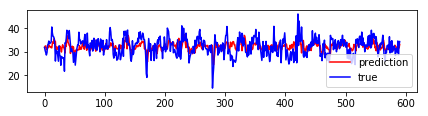

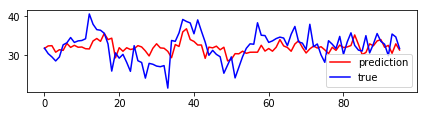

In [53]:
plot_result(test_result,test_label1,path)
#plot_error(train_rmse,train_loss,test_rmse,test_acc,test_mae,path)